# <font color='289C4E'> 1. Importing Libraries <a class='anchor' id='pytorch'></a> [↑](#top)
Below are the required libraries.
* pytorch will be used along with visualization of network by torchview
* Because the VGG16 network is trained on Imagenet data set with mean and standard deviation as given below, we need to take care of them when we are considering the final stylized image, i.e multiply the standard deviation and add the mean to the image tensor

In [1]:
#Loading Libraries

!pip install torchview

import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
import shutil
from torchview import draw_graph
from time import perf_counter, sleep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mean and standard deviation used for training

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

We are making a image directory here to use it train the model on batches of images. This test dataset has total 40670 images. We will use all of them for training the model in batches of 10.

In [2]:
source = "/kaggle/input/coco-2017-dataset/coco2017/test2017"
dest = "Train_image/Data"
shutil.copytree(source,dest)

'Train_image/Data'

# <font color='289C4E'> 2. Utility Functions <a class='anchor' id='utility'></a> [↑](#top)
These functions help in the training process from preprocessing the input image to calculating the gram-matrix for loss calculation and also reverse processing the image for visualization

In [3]:
def gram_matrix(y): 
    """ Returns the gram matrix of y (used to compute style loss) """
    Layer = list(y.keys())
    G = {}
    for layer in Layer:
        A=y[layer]
        (b, c, h, w) = A.size()
        features = A.view(b, c, w * h)
        features_t = features.transpose(1, 2)
        G[layer] = features.bmm(features_t) / (c * h * w)
    return G


def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    """ Transforms for test image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

# <font color='289C4E'> 3. Networks <a class='anchor' id='net'></a> [↑](#top)
The below models are according to the paper produced by [Johnson et al.](https://arxiv.org/abs/1603.08155)

They used a Transformer network (Feedforward block) linked to the VGG16 net. The VGG net is used for feature extraction from the style image, content image and generated target image
<div style="width:100%;text-align: center;"> <img align=middle src="https://www.dropbox.com/s/dw5e9brvwqupfln/NST-paper.jpg?raw=1" alt="Heat beating" style="height:200px;margin-top:3rem;"> </div>
<center>Transformer and Extractor Network</center>
<br>

The features are extracted from pre-trained `VGG16 net` from the same convolution blocks as show above. Original Paper uses batch normalization, but I found it causes the  image to be darker. Instead Instance normalization gives a brighter look image. So I will use Instance Normalization



In [4]:
from torchvision.models import VGG16_Weights

""" VGG16 Model """
class VGG16(nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = {"relu1_2": h_relu1_2, "relu2_2": h_relu2_2, "relu3_3": h_relu3_3, "relu4_3": h_relu4_3}
        return vgg_outputs


""" Transformer Net """
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1,padding = 4,padding_mode = 'reflect')
        self.bn1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2,padding = 1,padding_mode = 'reflect')  
        self.bn2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2,padding = 1,padding_mode = 'reflect')
        self.bn3 = nn.InstanceNorm2d(128, affine=True)
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.transposeConv1 = TransposeConv(128,64,kernel_size=2,stride=2)
        self.transposeConv2 = TransposeConv(64,32,kernel_size=2,stride=2)
        self.conv5 = nn.Conv2d(32,3,kernel_size=9,stride=1,padding = 4,padding_mode = 'reflect')

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.transposeConv1(x)
        x = self.transposeConv2(x)
        x = self.conv5(x)
        return x

class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1,padding_mode='reflect')
        self.bn1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1,padding_mode='reflect')
        self.bn2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        skip = x
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return x + skip

class TransposeConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(TransposeConv, self).__init__()
        self.tconv = nn.ConvTranspose2d(in_channels,out_channels, kernel_size,stride)
        self.bn = nn.InstanceNorm2d(out_channels, affine=True)
    def forward(self,x):
        x = nn.functional.relu(self.bn(self.tconv(x)))
        return x

In [5]:
Model1 = VGG16()
Model2 = TransformerNet()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 289MB/s]


# <font color='289C4E'> 4. Model Architecture <a class='anchor' id='arch'></a> [↑](#top)
As per the paper the model architectures are shown below.

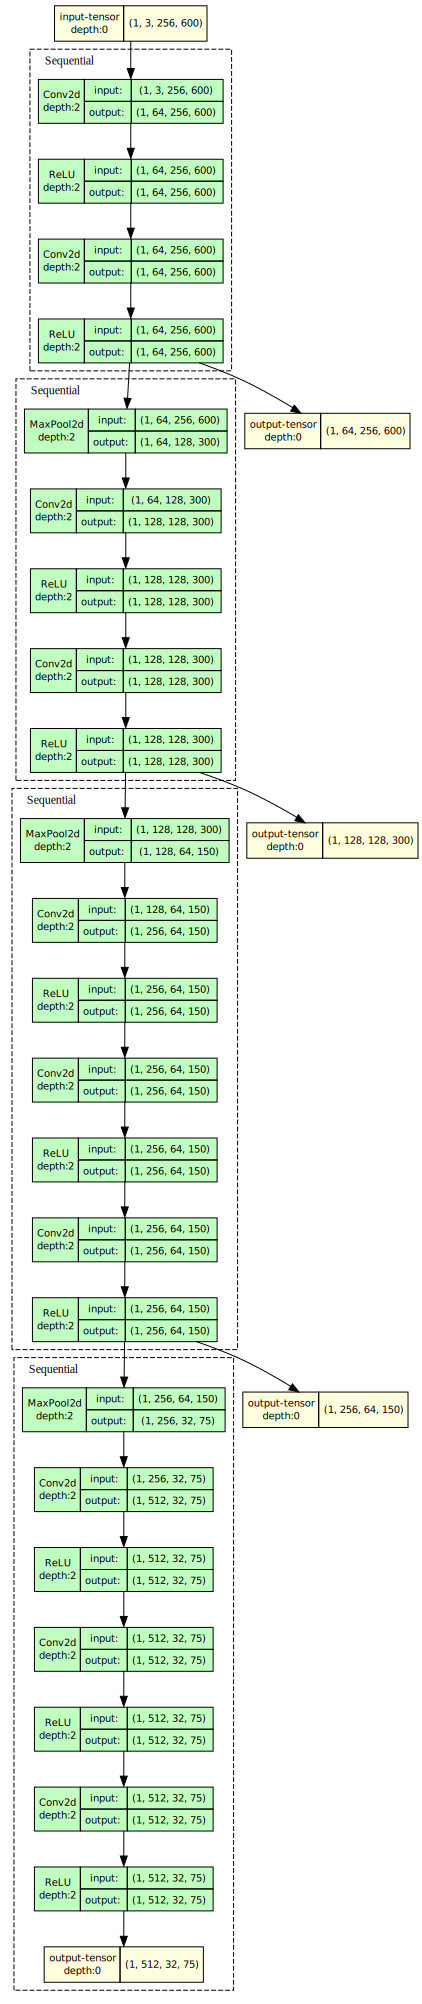

In [6]:
#Model visualisation

model_graph = draw_graph(Model1,input_size=(1,3,256,600), expand_nested=True)
model_graph.resize_graph(scale=10.0)
model_graph.visual_graph

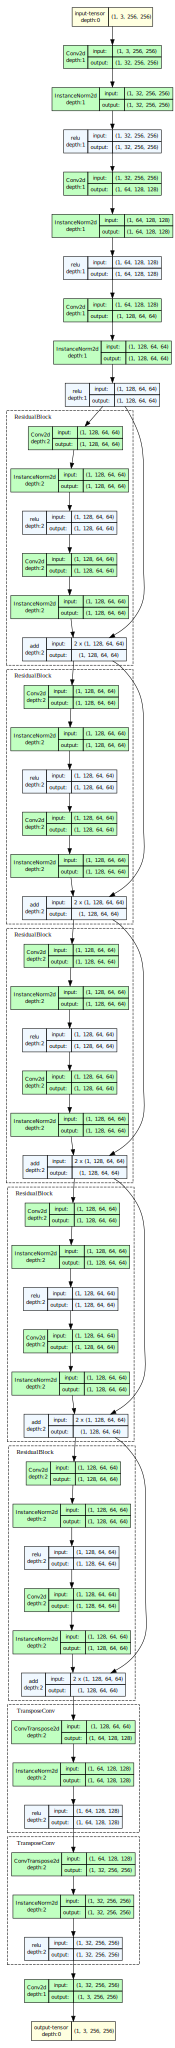

In [7]:
#Model visualization

model_graph = draw_graph(Model2,input_size=(1,3,256,256), expand_nested=True)
model_graph.resize_graph(scale=10.0)
model_graph.visual_graph

# <font color='289C4E'> 4. Training Loop <a class='anchor' id='Train'></a> [↑](#top)
We used dataloader to load images in batches. This function makes use of all the utility functions and networks that is defined above. 
* The original paper uses LBFGS optimizer. But because it is not available in the pytorch module I will use adam optimizer with a base learning rate of 0.001. I further used exponential learning rate decay of 0.1 for the batches multiples of 2 onwards.
* Because training on 40670 images will be very time consuming even on GPU, I decided to use only two epochs. The results would be much better for 4-5 epochs.     
   

In [8]:
"""
inicijalni parametri(ovako je bilo)
image_size=256,
style_size=480,
batch_size = 10,
lr = 1e-3,
epochs = 1,
lambda_style=10e9,
lambda_content=10e4,decayRate = 0.1)
"""

def Train(style_image,        
                 dataset_path,   
                 image_size=256,
                 style_size=480,
                 batch_size = 10,
                 lr = 1e-3,
                 epochs = 1,
                 lambda_style=10e9,
                 lambda_content=10e4,decayRate = 0.1):


    """ Create dataloader for the training data """
    train_dataset = datasets.ImageFolder(dataset_path, train_transform(image_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size)

    """ Define networks """
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

   
    """ Define optimizer and loss """
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

    """ Load style image """
    style = style_transform(style_size)(Image.open(style_image))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    """ Extract style features """
    features_style = vgg(style)
    gram_style = gram_matrix(features_style)
    
    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        if (epoch+1) % 2 == 0:
            lr_scheduler.step()
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = lambda_content * l2_loss(features_transformed["relu2_2"], features_original["relu2_2"])

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            features_gram = gram_matrix(features_transformed)
            for ft_y, gm_s in zip(features_gram, gram_style):
                style_loss += l2_loss(features_gram[ft_y], gram_style[gm_s][: images.size(0), :, :])
            style_loss *= lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]
            
            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i+1,
                    len(train_dataset)/10,
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )
        # debugging purpose
        print('lr: ',lr_scheduler.get_last_lr())      
            
    print("Training Completed!")
    
    #printing the loss curve.
    plt.plot(train_metrics["content"], label = "Content Loss")
    plt.plot(train_metrics["style"], label = "Style Loss")
    plt.plot(train_metrics["total"], label = "Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()
    
    return transformer

# <font color='289C4E'> 6. Style Images <a class='anchor' id='st'></a> [↑](#top)

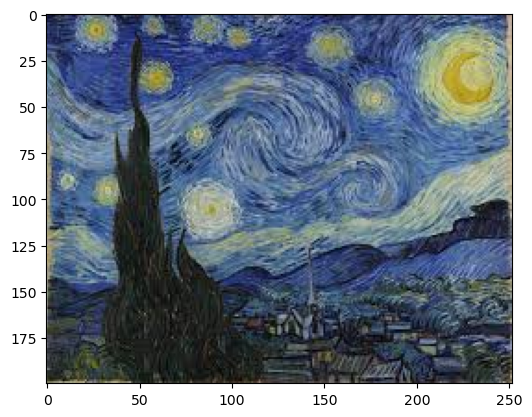

In [9]:
#Style Image

img_style = Image.open('/kaggle/input/style-images/style_images/starry_night.jfif')
plt.imshow(img_style)
plt.show()

# <font color='289C4E'> 6. Content Images <a class='anchor' id='c'></a> [↑](#top)

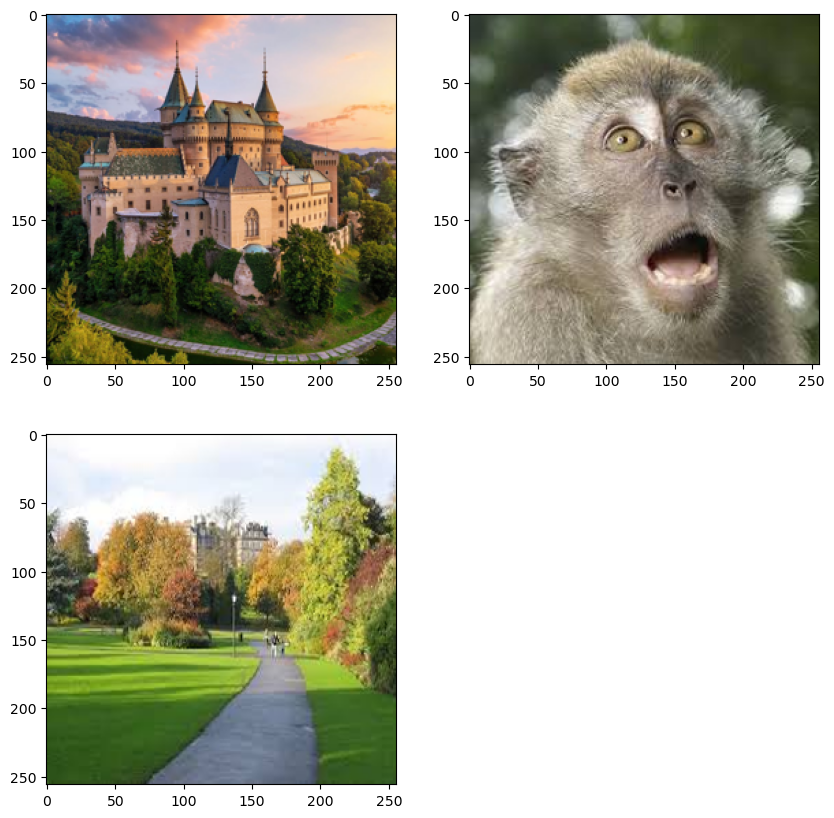

In [10]:
#Original Content Images

img1 = Image.open('/kaggle/input/content-images/content_images/castle.jpg').resize((256, 256))
img2 = Image.open('/kaggle/input/content-images/content_images/monkey.jfif').resize((256, 256))
img3 = Image.open('/kaggle/input/content-images/content_images/park.jfif').resize((256, 256))

images = [img1,img2,img3]

plt.figure(figsize=(10,10))

for i,img in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.imshow(img)

[Epoch 1/1] [Batch 4067/4067] [Content: 217791.94 (373217.84) Style: 89561.70 (203845.26) Total: 307353.62 (577063.10)]lr:  [0.001]
Training Completed!


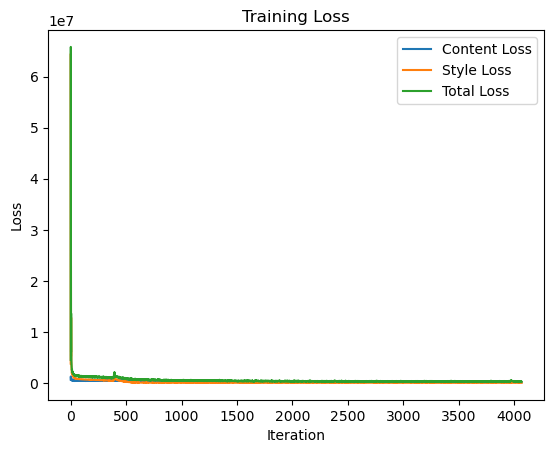

Time taken to execute code : 1382.733990697 sec


In [11]:
start = perf_counter()
Model_style_1 = Train(style_image='/kaggle/input/style-images/style_images/starry_night.jfif',
             dataset_path = '/kaggle/working/Train_image', epochs = 1)

end = perf_counter()
print(f"Time taken to execute code : {end-start} sec")
torch.save(Model_style_1.state_dict(), '/kaggle/working/model_style_1.pth')

# <font color='289C4E'> 7. Final Stylized Images <a class='anchor' id='f'></a> [↑](#top)

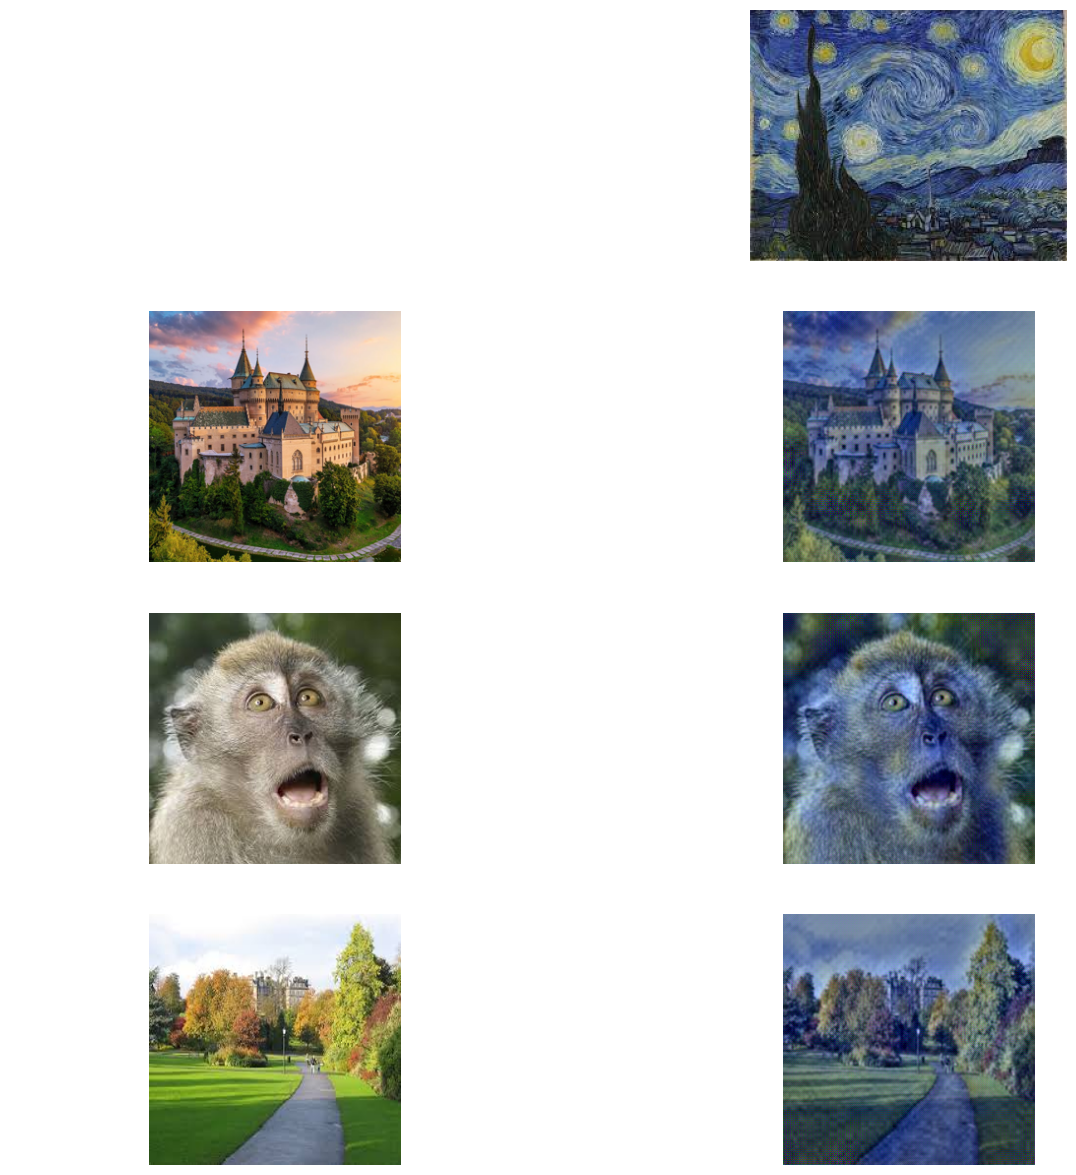

In [12]:
"""
loading model
Model_style_1 = TransformerNet()
Model_style_1.load_state_dict(torch.load('/kaggle/working/model_style_1.pth'))
"""

transform = test_transform()
image_tensor = Variable(transform(Image.open('/kaggle/input/content-images/content_images/castle.jpg').resize((256, 256)))).to(device)
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    image1_style1 = deprocess(Model_style_1(image_tensor))

transform = test_transform()
image_tensor = Variable(transform(Image.open('/kaggle/input/content-images/content_images/monkey.jfif').resize((256, 256)))).to(device)
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    image2_style1 = deprocess(Model_style_1(image_tensor))

transform = test_transform()
image_tensor = Variable(transform(Image.open('/kaggle/input/content-images/content_images/park.jfif').resize((256, 256)))).to(device)
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    image3_style1 = deprocess(Model_style_1(image_tensor))
    
images = [image1_style1,image2_style1,image3_style1] 

"""
plt.subplot(3,1,1)
plt.imshow(images[0])
plt.show()

plt.subplot(3,1,2)
plt.imshow(images[1])
plt.show()

plt.subplot(3,1,3)
plt.imshow(images[2])
plt.show()
"""

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(15,15))

axes[0,0].axis('off')

axes[0,1].imshow(img_style)
axes[0,1].axis('off')

axes[1,0].imshow(img1)
axes[1,0].axis('off')
axes[1,1].imshow(image1_style1)
axes[1,1].axis('off')

axes[2,0].imshow(img2)
axes[2,0].axis('off')
axes[2,1].imshow(image2_style1)
axes[2,1].axis('off')

axes[3,0].imshow(img3)
axes[3,0].axis('off')
axes[3,1].imshow(image3_style1)
axes[3,1].axis('off')

plt.savefig('/kaggle/working/combined_images.png', bbox_inches='tight')

In [13]:
plt.imsave('/kaggle/working/image1_style1.png',image1_style1)
plt.imsave('/kaggle/working/image2_style1.png', image2_style1)
plt.imsave('/kaggle/working/image3_style1.png', image3_style1)